In [1]:
import perceval as pcvl
import perceval.components as comp
import numpy as np
import networkx as nx
from scipy.linalg import sqrtm
from perceval.algorithm import Sampler
from scipy.special import binom
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [2]:
def create_graph(n,p=0.5):
    graph = nx.erdos_renyi_graph(n=n,p=p)
    graph.inflow=1
    graph.outflow=0
    return graph

def gen_graph_scalefree(n):
    G=nx.scale_free_graph(n, alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, seed=None, initial_graph=None)
    G2 = G.to_undirected()
    G2.remove_edges_from(nx.selfloop_edges(G2))
    G2.inflow=1
    G2.outflow=0
    return G2

In [3]:
def order_of_magnitude(number):
    if number == 0:
        return -20
    try:
        return math.floor(math.log(abs(number), 10))
    except:
        return -20

def to_unitary(A):
    ''' Input: graph A either as:
                                 an adjacency matrix of size mxm
                                 a networkX graph with m nodes
        Output: unitary with size 2mx2m
    '''
    if isinstance(A, nx.Graph):
        A = nx.to_numpy_array(A)
    P, D, V = np.linalg.svd(A)
    m = len(A)
    lsv = np.max(D)
    An = A/lsv
    P = An
    if all([order_of_magnitude(value.real)<-9 for row in np.identity(m)-np.dot(An, An.conj().T) for value in row]):
        print("forcing Q = R = zeros")
        Q = R = np.zeros((m,m))
    else:
        Q = sqrtm(np.identity(m)-np.dot(An, An.conj().T))
        R = sqrtm(np.identity(m)-np.dot(An.conj().T, An))
    S = -An.conj().T
    Ubmat = np.bmat([[P, Q], [R, S]])
    Ubmat = Ubmat.real
    return (np.copy(Ubmat), lsv)

In [4]:
def input_DS(m, k):
    '''input state for selection columns
             m - number of subgraphs
             k - size of each subgraph (size to identify)
        returns |1,1,1,...,0,0,0> k ones and k*m-k zeros'''
    return np.append(np.append(np.ones(k), np.zeros(k*m-k)), np.zeros(k*m)).astype(int)

In [5]:
def post_selectionDS(samples, k):
    n_subg = int(len(samples[0])/2/k)
    accepted = [sample for sample in samples for i in range(n_subg) if all(sample[k*i:k*i+k]) == 1]
    return accepted

In [6]:
# Functions to generate the subgraphs to test
def test_subgraphs(G, subG, size):
    ''' inputs: 
                G - networkX graph 
                subG - list of nodes for selected subgraph
                size - integer for size of subgraph to find
        return:
                all remaining possible subgraphs of size "size"-len(subG)'''

    G_n = len(G.nodes)
    subG_n = len(subG)
    num_subgraphs = binom(G_n-subG_n, size-subG_n)
    print("Number of possible subgraphs:", num_subgraphs)

    nodes = list(G.nodes)
    test_nodes = [node for node in nodes if node not in subG]
    test_list = list(itertools.combinations(test_nodes, size-subG_n))

    poss_subg = [subG+list(i) for i in test_list]
    return poss_subg


In [7]:
# Functions to generate the subgraphs to test
def construct_B(G, subG, k):
    ''' inputs: 
                G - networkX graph 
                subG - list of nodes for selected subgraph
                k - integer for size of subgraph to find
        return:
                matrix B containing all possible subgraphs of size k - dimensions are k*len(sub_m), k*len(sub_m)'''

    G_n = len(G.nodes)
    subG_n = len(subG)
    num_subgraphs = int(binom(G_n-subG_n, k-subG_n))
    #print("Number of combinations for subgraphs:", num_subgraphs)

    nodes = list(G.nodes)
    test_nodes = [node for node in nodes if node not in subG]
    test_list = list(itertools.combinations(test_nodes, k-subG_n))

    poss_subg = [subG+list(i) for i in test_list]

    # Construction of B
    sub_m = [nx.convert_matrix.to_numpy_array(
        G.subgraph(sub_nodes)) for sub_nodes in poss_subg]
    B = np.zeros((k*num_subgraphs, k*num_subgraphs))
    for i, j in enumerate(sub_m):
        B[k*i:k*i+k, 0:k] = j
    return (B, poss_subg)

In [8]:
def densest_subgraphs(G, k=None, seed=[], nb_samples=100, Ns_min=100, preview=False):
    '''Input: G - networkX graph to test 
              Ns - number of samples to generate with quantum device
              seed - subgraph identified from optimized classical algorithm
    return: subgraphs by order of selection'''
    if not k: k = int(len(G.nodes)/2)
    
    # Initialization and preparing the device
    B = construct_B(G, seed, k)
    print(B[0].shape)
    in_state = input_DS(int(len(B[0])/k), k)
    U, c = to_unitary(B[0])

    unitary_component = comp.Unitary(pcvl.Matrix(U))
    proc = pcvl.Processor("CliffordClifford2017", unitary_component)
    proc.with_input(pcvl.BasicState(in_state))

    # generating samples
    samples = []
    i = 0
    sampler = Sampler(proc)
    while len(samples) < Ns_min:
        samples_device = sampler.samples(nb_samples)['results']
        new_generation_samples = post_selectionDS(samples_device, k)
        samples += new_generation_samples
        i = i+1

    timesG = np.zeros(len(B[1]))
    if preview: print("Number of samples: ", len(samples), "\nTotal samples generated:", nb_samples*i)
    for sample in samples:
        indexG = list(sample).index(1)
        timesG[int(indexG/k)] = timesG[int(indexG/k)]+1
    return sorted(zip(timesG, B[1]), reverse=True)

In [9]:
def delete_weakest_link(graph,chosen_edge):
    nodes = list(graph.nodes())
    graph.remove_edge(nodes[chosen_edge[0]], nodes[chosen_edge[1]])
    return graph

#### Example

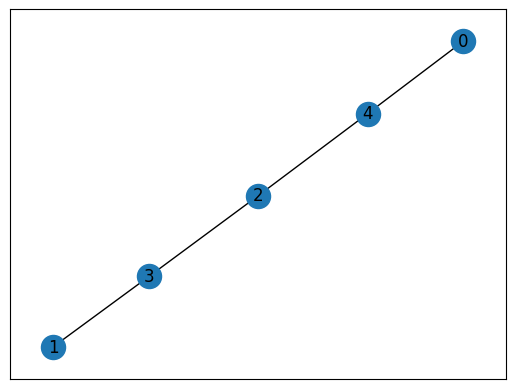

In [10]:
g = create_graph(n=5)
nx.draw_networkx(g)

In [11]:
%%time
res = densest_subgraphs(g,preview=True)
print(res)

(20, 20)
Number of samples:  113 
Total samples generated: 400
[(32.0, [2, 4]), (29.0, [1, 3]), (28.0, [0, 4]), (24.0, [2, 3]), (0.0, [3, 4]), (0.0, [1, 4]), (0.0, [1, 2]), (0.0, [0, 3]), (0.0, [0, 2]), (0.0, [0, 1])]
CPU times: user 466 ms, sys: 6.86 ms, total: 473 ms
Wall time: 62.7 ms


#### Strategy: removing weak links

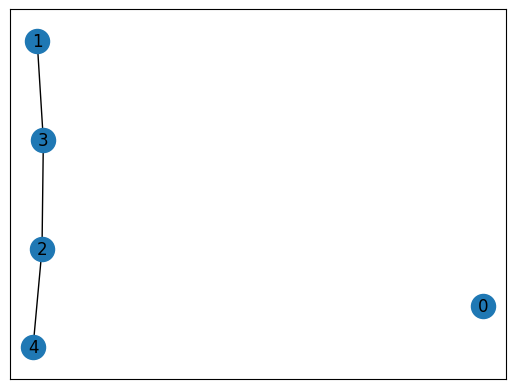

In [12]:
g = create_graph(n=5)
nx.draw_networkx(g)

In [13]:
num_iterations = 5

In [15]:
for i in tqdm(range(num_iterations)):
    try:
        res = densest_subgraphs(g,preview=True)
        densest_subgraph = res[0][-1]
        delete_weakest_link(g,densest_subgraph)
        #calculate total flux
    except:
        pass

  0%|                                                     | 0/5 [00:00<?, ?it/s]/var/folders/lq/shl3t2n51mgdksn52y8zz7t00000gn/T/ipykernel_837/1764168611.py:20: RuntimeWarning: invalid value encountered in divide
  An = A/lsv
100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 177.75it/s]

(20, 20)
forcing Q = R = zeros
(20, 20)
forcing Q = R = zeros
(20, 20)
forcing Q = R = zeros
(20, 20)
forcing Q = R = zeros
(20, 20)
forcing Q = R = zeros
